In [23]:
import hashlib
import numpy as np
import math
import collections
from zlib import crc32
import random
import operator
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.optimize import brentq
from sympy import Symbol, solve, log
from scipy.optimize import fsolve
import scipy
import hashlib
import array
import matplotlib.cm as cm
import operator
from collections import defaultdict
import pandas as pd
import matplotlib
print('matplotlib: {}'.format(matplotlib.__version__)) 
# use matplotlib: 3.1.0



matplotlib: 3.1.0


In [4]:
from spacesaving import SpaceSaving
from githubCountMin import CountMinSketch
from CSSS import CSSS_CountSketch, CSSS_sketch

In [5]:
    # A simple test
    test = SpaceSaving(2)
    stream = ['a','b','c', 'a', 'a','-a']
    dic = defaultdict(int)
    for item in stream:
        if len(item) == 1:
            test.update(item, 1)
            dic[item]+=1
        else:
            test.update(item[1:], -1)
            dic[item[1:]] -= 1
    test.output()
    print("item, F', F")
    for item in set(stream):
        if len(item) == 1:
            print(item, test.query(item), dic[item])

weight_heap:  [['c', 2], ['a', 2]]
error_heap (-1*error):  [['c', -1], ['a', -1]]
map:  defaultdict(<class 'list'>, {'c': [0, 0], 'a': [1, 1]})
item, F', F
a 2 2
b 0 1
c 2 1


In [18]:
    def create_recall(stream_type, arr, skew=1.0, s = 10**5, u = 2**16):
        phis = []
        if stream_type == "zipf":
            phis = [2**(-4),2**(-5),2**(-6), 2**(-7)]
        elif stream_type == "bin":
            phis = [2**(-9),2**(-10),2**(-11), 2**(-12)]
        else:
            phis = [2**(-7),2**(-8),2**(-9), 2**(-10)]
        
        ss_recall = {}
        lazy_ss_recall = {}
        csss_recall = {}
        cm_recall = {}
        cs_recall = {}

        total_spaces = {}
        Turnstile_model_maker = ['^:','^-.']
        markers = {0.5:['kv-','kv--','kv:', '*:', '*-.']}

        runs = 5
        universe = u
        size = s
        a = skew
        rates = [0.5]
        alphas = [2]
        p = 0.1
        
        for i in range(len(rates)):
            rate = rates[i]
            alpha = alphas[i]

            ss_avg_recalls = []        
            lazy_ss_avg_recalls  = []
            csss_avg_recalls = []        
            cm_avg_recalls = []
            cs_avg_recalls = []

            total_space = []

            for j in range(len(phis)):
            
                sum_ss_avg_recall = 0
                sum_lazy_ss_avg_recall = 0        
                sum_csss_avg_recall = 0           
                sum_cm_avg_recall = 0            
                sum_cs_avg_recall = 0

                phi = phis[j]
                epsilon_prime = phi/32
                k = 1/epsilon_prime
                first_run = True
            
                for run in range(runs):
                    ss_space = math.ceil(alpha/phi) #number of counters
                    SS = SpaceSaving(ss_space)
                    LAZY_SS = SpaceSaving(ss_space, True)
                    CM = CountMinSketch( math.ceil((1.0/phi)), math.ceil(math.log2(universe))) #cols, rows
                    CS = CSSS_CountSketch(math.ceil(math.log2(universe)), math.ceil((1.0/phi)))

                    if first_run:
                        first_run = False
                        temp = total_spaces.get("SS"+str(rate), [])
                        temp.append(ss_space*math.log2(universe))
                        total_spaces["SS"+str(rate)] = temp

                        temp = total_spaces.get("CM"+str(rate), [])
                        temp.append( ss_space*math.log2(universe)*math.log2(universe)/2.0)
                        total_spaces["CM"+str(rate)] = temp
                    
                    insertions = []
                    deletions = []
                    
                    if stream_type == "zipf":
                        range_x = np.arange(1,universe)
                        weights = range_x ** (-a)
                        weights /= weights.sum()
                        bounded_zipf = stats.rv_discrete(name='bounded_zipf', values=(range_x, weights))

                        insert_size = int(size/(1-rate))
                        insertions = bounded_zipf.rvs(size=insert_size) 
                        
                        deletions = random.sample(list(insertions), int(rate*insert_size))
                        
                    elif stream_type == "bin":
                        insert_size = int(size/(1-rate))
                        insertions = list(np.random.binomial(u, p, insert_size))
                        deletions = random.sample(list(insertions), int(rate*insert_size))
                            
                    else:
                        insertions = arr[run*CAIDASIZE:(run+1)*CAIDASIZE]
                        deletions = random.sample(list(insertions), int(rate*CAIDASIZE))
                    
                    true_result = {}
                    for item in insertions:
                        SS.update(str(item), 1)
                        LAZY_SS.update(str(item), 1)
                        true_result[str(item)] = true_result.get(str(item), 0) + 1
                        CM.add(str(item), 1)
                        CS.add(str(item), 1)

                    for item in deletions:
                        SS.update(str(item), -1)
                        LAZY_SS.update(str(item), -1)
                        true_result[str(item)] -= 1
                        CM.add(str(item), -1)
                        CS.add(str(item), -1)

                    true_frequent_items = set()
                    frequent_threshold = phi*(len(insertions)-len(deletions))
                    for key, val in true_result.items():
                        if val > frequent_threshold:
                            true_frequent_items.add(key)
                            
                    ss_avg_tp = 0
                    lazy_ss_avg_tp = 0
                    cm_avg_tp = 0
                    cs_avg_tp = 0

                    ss_avg_fn = 0
                    lazy_ss_avg_fn = 0
                    cm_avg_fn = 0
                    cs_avg_fn = 0
                
                    for item in true_frequent_items:
                        if SS.query(item) > frequent_threshold:
                            ss_avg_tp+=1
                        else:
                            ss_avg_fn+=1

                        if LAZY_SS.query(item) > frequent_threshold:
                            lazy_ss_avg_tp+=1
                        else:
                            lazy_ss_avg_fn+=1

                        if rate == 0.5:
                            cm_estimate = CM.query(item)
                            if cm_estimate > frequent_threshold:
                                cm_avg_tp+=1
                            else:
                                cm_avg_fn+=1

                            cs_estimate = CS.query(item)
                            if cs_estimate > frequent_threshold:
                                cs_avg_tp+=1
                            else:  
                                cs_avg_fn+=1

                    ss_avg_recall = 1.0*ss_avg_tp / (ss_avg_tp +ss_avg_fn)
                    lazy_ss_avg_recall = 1.0*lazy_ss_avg_tp / (lazy_ss_avg_tp+lazy_ss_avg_fn)
                    if rate == 0.5:
                        cm_avg_recall = 1.0*cm_avg_tp / (cm_avg_tp + cm_avg_fn)
                        cs_avg_recall = 1.0*cs_avg_tp / (cs_avg_tp + cs_avg_fn)

                    sum_ss_avg_recall += ss_avg_recall
                    sum_lazy_ss_avg_recall += lazy_ss_avg_recall
                    if rate == 0.5:
                        sum_cm_avg_recall += cm_avg_recall
                        sum_cs_avg_recall += cs_avg_recall

                ss_avg_recalls.append(sum_ss_avg_recall/ runs)
                lazy_ss_avg_recalls.append(sum_lazy_ss_avg_recall/ runs)
                cm_avg_recalls.append(sum_cm_avg_recall/ runs)
                cs_avg_recalls.append(sum_cs_avg_recall/ runs)
        
            ss_recall[rate] = ss_avg_recalls
            lazy_ss_recall[rate] = lazy_ss_avg_recalls

            cm_recall[rate] = cm_avg_recalls
            cs_recall[rate] = cs_avg_recalls
        

        fig = plt.figure()
        if stream_type == "zipf":
            plt.title("Zipf("+str(a)+")", fontsize=16) 

        elif stream_type == "bin":
            plt.title("Binomial("+str(p)+")", fontsize=16) 

        else:
            plt.title("CAIDA", fontsize=16) 
            
        plt.xlabel('\u03C6', fontsize=14)
        plt.ylabel('Recall', fontsize=14)
        plt.xscale('log', basex=2)
        position = [[],[],[],[],[]]
        widths = [[],[],[],[]]
        position_arr = []
        if stream_type == 'zipf':
            position_arr = [(-7.5, -6.5),(-6.5, -5.5),(-5.5, -4.5),(-4.5, -3.5)]
        elif stream_type == 'bin':
            position_arr = [(-12.5, -11.5),(-11.5, -10.5),(-10.5, -9.5),(-9.5, -8.5)]
        else:
            position_arr = [(-10.5, -9.5),(-9.5, -8.5),(-8.5, -7.5),(-7.5, -6.5)]
            
        for start,end in position_arr:
            x = np.logspace(start,end, num=6, base=2) 
            w = np.diff(x)
            temp = 0
            for idx, item in enumerate(x[1:-1]):
                position[temp%4].insert(0,item)
                temp+=1
            temp = 0
            for i in w[1:]:
                widths[temp%4].insert(0,i)
                temp+=1

        ax = fig.add_subplot(111)
        ax.xaxis.set_ticks_position('none') 
        ax2 = ax.twinx()
        ax2.set_ylabel("Space(bits)")
        ax2.set_yscale('log', basey=2)

        print(position[1])
        print(widths[1])
        
        
        for i in range(1):
            b1 = ax.bar(position[0], ss_recall[rates[i]], width=widths[0], color = 'dimgrey', label='SpaceSaving\u00B1')
            b2 = ax.bar(position[1], lazy_ss_recall[rates[i]], width=widths[1], color = 'silver',label='Lazy')
            b4 = ax.bar(position[2], cm_recall[rates[i]], width=widths[2], color = 'cornflowerblue', label='Count-Min')
            b5 = ax.bar(position[3], cs_recall[rates[i]], width=widths[3], color = 'bisque', label='Count Median')

        for i in range(1):
            l6 = ax2.plot(phis, total_spaces['SS0.5'], 'x--', color = 'k', label='SpaceSaving\u00B1 Space')
            l7 = ax2.plot(phis, total_spaces['CM0.5'], 'v--', color = 'red', label='CMin/CMedian Space')
        
        ax.legend(prop={'size': 10}, loc='lower left')
        ax2.legend(prop={'size': 10}, loc='lower right')
        
        plt.show()
        print("SS:", ss_recall)
        print("Lazy SS:", lazy_ss_recall)
        print("CM:", cm_recall)
        print("CS:", cs_recall)

/Users/owner/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:207: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


[0.0018223300615953274, 0.0009111650307976637, 0.00045558251539883185, 0.00022779125769941593]
[0.0002709774824208697, 0.00013548874121043484, 6.774437060521742e-05, 3.387218530260871e-05]


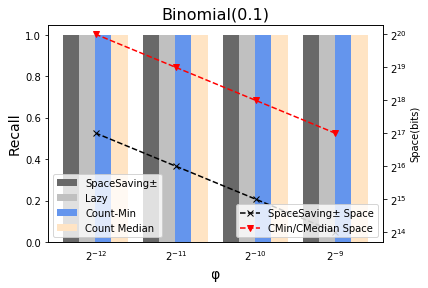

SS: {0.5: [1.0, 1.0, 1.0, 1.0]}
Lazy SS: {0.5: [1.0, 1.0, 1.0, 1.0]}
CM: {0.5: [1.0, 1.0, 1.0, 1.0]}
CS: {0.5: [0.998152415087899, 1.0, 1.0, 1.0]}


In [19]:
     create_recall("bin", [], 0.1)

0.0625
0.03125
0.015625
0.0078125


/Users/owner/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:203: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


[0.05831456197105048, 0.02915728098552524, 0.01457864049276262, 0.00728932024638131]
[0.008671279437467844, 0.004335639718733915, 0.0021678198593669575, 0.0010839099296834787]


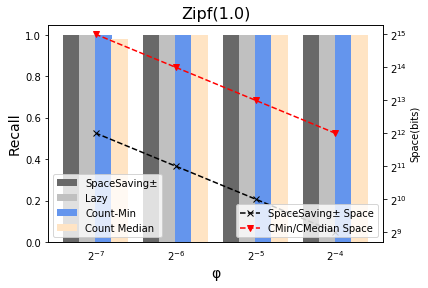

SS: {0.5: [1.0, 1.0, 1.0, 1.0]}
Lazy SS: {0.5: [1.0, 1.0, 1.0, 1.0]}
CM: {0.5: [1.0, 1.0, 1.0, 1.0]}
CS: {0.5: [1.0, 1.0, 1.0, 0.9800000000000001]}


In [44]:
    create_recall("zipf", [], 1.0)

20530780
0.0078125


/Users/owner/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: overflow encountered in long_scalars
/Users/owner/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: overflow encountered in long_scalars
/Users/owner/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: overflow encountered in long_scalars
/Users/owner/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: overflow encountered in long_scalars


0.00390625
0.001953125
0.0009765625


/Users/owner/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:203: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


[0.00728932024638131, 0.003644660123190655, 0.0018223300615953274, 0.0009111650307976637]
[0.0010839099296834787, 0.0005419549648417394, 0.0002709774824208697, 0.00013548874121043484]


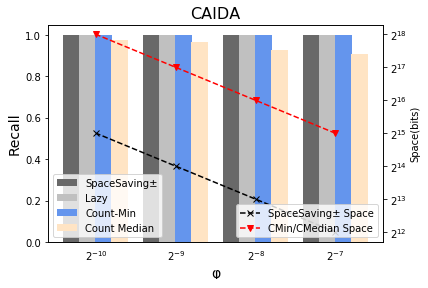

SS: {0.5: [1.0, 1.0, 1.0, 1.0]}
Lazy SS: {0.5: [1.0, 1.0, 1.0, 1.0]}
CM: {0.5: [1.0, 1.0, 1.0, 1.0]}
CS: {0.5: [0.9099999999999999, 0.9295402298850576, 0.966897730430093, 0.9738238573533069]}


In [45]:
df = pd.read_csv('./data/tcp/20151217_125911_dirA.csv',sep='\t')  
dip = df[df.columns[3]]
create_recall("CAIDA", dip)

In [21]:
    def create_percision(stream_type, arr, skew=1.0, s = 10**5, u = 2**16):
        phis = []
        if stream_type == "zipf":
            phis = [2**(-4),2**(-5),2**(-6), 2**(-7)]
        elif stream_type == "bin":
            phis = [2**(-9),2**(-10),2**(-11), 2**(-12)]
        else:
            phis = [2**(-7),2**(-8),2**(-9), 2**(-10)]
        
        ss_percision = {}
        lazy_ss_percision = {}
        csss_percision = {}
        cm_percision = {}
        cs_percision = {}
        total_spaces = {}
        Turnstile_model_maker = ['^:','^-.']
        markers = {0.5:['kv-','kv--','kv:', '*:', '*-.']}

        runs = 5
        universe = u
        size = s
        a = skew
        rates = [0.5]
        alphas = [2]
        p = 0.1
        
        
        for i in range(len(rates)):
            rate = rates[i]
            alpha = alphas[i]

            ss_avg_percisions = []        
            lazy_ss_avg_percisions = []
            csss_avg_percisions = []        
            cm_avg_percisions = []
            cs_avg_percisions = []

            total_space = {}
            

            for j in range(len(phis)):

                sum_ss_avg_percision = 0
                sum_lazy_ss_avg_percision = 0        
                sum_csss_avg_percision = 0           
                sum_cm_avg_percision = 0            
                sum_cs_avg_percision = 0

                phi = phis[j]
                epsilon_prime = phi/32
                k = 1/epsilon_prime

                print(phi)
                first_run = True
                run = 0
                while run < runs:
                    run += 1
                    ss_space = math.ceil(alpha/phi) # number of counters
                    SS = SpaceSaving(ss_space)
                    LAZY_SS = SpaceSaving(ss_space, True)

                    CM = CountMinSketch( math.ceil((1.0/phi)), math.ceil(math.log2(universe))) # cols, rows
                    CS = CSSS_CountSketch(math.ceil(math.log2(universe)), math.ceil((1.0/phi)))

                        
                    insertions = []
                    deletions = []
                    
                    if stream_type == "zipf":
                        range_x = np.arange(1,universe)
                        weights = range_x ** (-a)
                        weights /= weights.sum()
                        bounded_zipf = stats.rv_discrete(name='bounded_zipf', values=(range_x, weights))

                        insert_size = int(size/(1-rate))
                        insertions = bounded_zipf.rvs(size=insert_size) 
                        deletions = random.sample(list(insertions), int(rate*insert_size))

                    elif stream_type == "bin":
                        insert_size = int(size/(1-rate))
                        insertions = list(np.random.binomial(u, p, insert_size))
                        deletions = random.sample(list(insertions), int(rate*insert_size))

                    else:
                        insertions = arr[run*CAIDASIZE:(run+1)*CAIDASIZE]
                        deletions = random.sample(list(insertions), int(rate*CAIDASIZE))

                    if first_run:
                        first_run = False
                        temp = []
                        temp = total_spaces.get("SS"+str(rate), [])
                        temp.append(ss_space*math.log2(universe))
                        total_spaces["SS"+str(rate)] = temp

                        temp = total_spaces.get("CM"+str(rate), [])
                        temp.append(ss_space*math.log2(universe)*math.log2(universe)/2.0)
                        total_spaces["CM"+str(rate)] = temp
                        

                    true_result = {}
                    for i in insertions:
                        SS.update(str(i), 1)
                        LAZY_SS.update(str(i), 1)
                        CM.add(str(i), 1)
                        CS.add(str(i), 1)
                        
                        true_result[str(i)] = true_result.get(str(i), 0) + 1

                    for i in deletions:
                        SS.update(str(i), -1)
                        LAZY_SS.update(str(i), -1)
                        true_result[str(i)] -= 1
                        CM.add(str(i), -1)
                        CS.add(str(i), -1)

                    true_frequent_items = set()
                    frequent_threshold = phi*(len(insertions)-len(deletions))
                    for key, val in true_result.items():
                        if val >= frequent_threshold:
                            true_frequent_items.add(key)

                    csss_avg_tp = 0
                    ss_avg_tp = 0
                    lazy_ss_avg_tp = 0
                    cm_avg_tp = 0
                    cs_avg_tp = 0

                    csss_avg_fp = 0
                    ss_avg_fp = 0
                    lazy_ss_avg_fp = 0
                    cm_avg_fp = 0
                    cs_avg_fp = 0


                    for item,_ in true_result.items():

                        if SS.query(item) >= frequent_threshold:
                            if item in true_frequent_items:
                                ss_avg_tp+=1
                            else:
                                ss_avg_fp+=1

                        if LAZY_SS.query(item) >= frequent_threshold:
                            if item in true_frequent_items:
                                lazy_ss_avg_tp+=1
                            else:
                                lazy_ss_avg_fp+=1

                        cm_estimate = CM.query(item)
                        if cm_estimate >= frequent_threshold:
                            if item in true_frequent_items:
                                cm_avg_tp+=1
                            else:
                                cm_avg_fp+=1

                        cs_estimate = CS.query(item)
                        if cs_estimate >= frequent_threshold:
                            if item in true_frequent_items:
                                cs_avg_tp+=1
                            else:  
                                cs_avg_fp+=1

                    
                    if lazy_ss_avg_tp+lazy_ss_avg_fp != 0:
                        lazy_ss_avg_percision = 1.0*lazy_ss_avg_tp / (lazy_ss_avg_tp+lazy_ss_avg_fp)
                    else:
                        print("need to be skewed")
                        exit()
                        
                    if (ss_avg_tp +ss_avg_fp ) != 0:
                        ss_avg_percision = 1.0*ss_avg_tp / (ss_avg_tp +ss_avg_fp )
                    else:
                        print("need to be skewed")
                        exit()
                        
                    if (cm_avg_tp + cm_avg_fp) != 0:
                        cm_avg_percision = 1.0*cm_avg_tp / (cm_avg_tp + cm_avg_fp)
                    else:
                        print("need to be skewed")
                        exit()
                        
                    if (cs_avg_tp + cs_avg_fp)!=0:
                        cs_avg_percision = 1.0*cs_avg_tp / (cs_avg_tp + cs_avg_fp)
                    else:
                        print("need to be skewed")
                        exit()

                    sum_ss_avg_percision += ss_avg_percision
                    sum_lazy_ss_avg_percision += lazy_ss_avg_percision
                    
                    sum_cm_avg_percision += cm_avg_percision
                    sum_cs_avg_percision += cs_avg_percision

                ss_avg_percisions.append(sum_ss_avg_percision/ runs)
                lazy_ss_avg_percisions.append(sum_lazy_ss_avg_percision/ runs)
                cm_avg_percisions.append(sum_cm_avg_percision/ runs)
                cs_avg_percisions.append(sum_cs_avg_percision/ runs)

            ss_percision[rate] = ss_avg_percisions
            lazy_ss_percision[rate] = lazy_ss_avg_percisions
            cm_percision[rate] = cm_avg_percisions
            cs_percision[rate] = cs_avg_percisions


        fig = plt.figure()
        if stream_type == "zipf":
                plt.title("Zipf("+str(a)+")", fontsize=16) 
        elif stream_type == "bin":
                plt.title("Binomial("+str(p)+")", fontsize=16) 
        else:
                plt.title("CAIDA", fontsize=16) 
            
            
        plt.xlabel('\u03C6', fontsize=14)
        plt.ylabel('Percision', fontsize=14)
        plt.xscale('log', basex=2)
        position = [[],[],[],[],[]]
        widths = [[],[],[],[]]
        if stream_type == 'bin':
            position_arr = [(-12.5, -11.5),(-11.5, -10.5),(-10.5, -9.5),(-9.5, -8.5)]
        else:
            position_arr = [(-10.5, -9.5),(-9.5, -8.5),(-8.5, -7.5),(-7.5, -6.5)]
            
        for start,end in position_arr:
            x = np.logspace(start,end, num=6, base=2) 
            w = np.diff(x)
            temp = 0
            for idx, item in enumerate(x[1:-1]):
                position[temp%4].insert(0,item)
                temp+=1
            temp = 0
            for i in w[1:]:
                widths[temp%4].insert(0,i)
                temp+=1

        ax = fig.add_subplot(111)
        ax.xaxis.set_ticks_position('none') 
        ax2 = ax.twinx()
        ax2.set_ylabel("Space(bits)")
        ax2.set_yscale('log', basey=2)

        print(position[1])
        print(widths[1])
        for i in range(1):
            b1 = ax.bar(position[0], ss_percision[rates[i]], width=widths[0], color = 'dimgrey', label='SpaceSaving\u00B1')
            b2 = ax.bar(position[1], lazy_ss_percision[rates[i]], width=widths[1],color = 'silver',label='Lazy')
            b4 = ax.bar(position[2], cm_percision[rates[i]], width=widths[2],color = 'cornflowerblue', label='Count-Min')
            b5 = ax.bar(position[3], cs_percision[rates[i]], width=widths[3],color = 'bisque', label='Count Median')

        for i in range(1):
            l6 = ax2.plot(phis, total_spaces['SS0.5'], 'kx--', label='SpaceSaving\u00B1 Space')
            l7 = ax2.plot(phis, total_spaces['CM0.5'], 'rx--',label='CMin/CMedian Space')
        
        ax.legend(prop={'size': 10}, loc='lower left')
        ax2.legend(prop={'size': 10}, loc='lower right')
        
        plt.show()
        print("SS:", ss_percision)
        print("Lazy SS:", lazy_ss_percision)
        print("CM:", cm_percision)
        print("CS:", cs_percision)

0.001953125
0.0009765625
0.00048828125
0.000244140625


/Users/owner/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:236: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


[0.0018223300615953274, 0.0009111650307976637, 0.00045558251539883185, 0.00022779125769941593]
[0.0002709774824208697, 0.00013548874121043484, 6.774437060521742e-05, 3.387218530260871e-05]


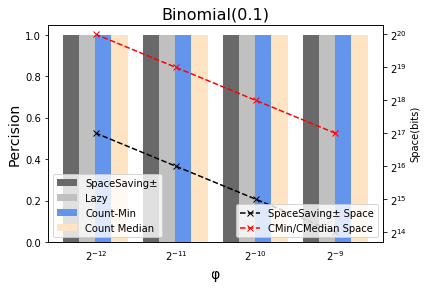

SS: {0.5: [1.0, 1.0, 1.0, 1.0]}
Lazy SS: {0.5: [1.0, 1.0, 1.0, 1.0]}
CM: {0.5: [1.0, 1.0, 1.0, 1.0]}
CS: {0.5: [0.998165137614679, 1.0, 1.0, 1.0]}


In [22]:
    create_percision("bin", [], 0.1)

0.0625
0.03125
0.015625
0.0078125


/Users/owner/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:234: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


[0.05831456197105048, 0.02915728098552524, 0.01457864049276262, 0.00728932024638131]
[0.008671279437467844, 0.004335639718733915, 0.0021678198593669575, 0.0010839099296834787]


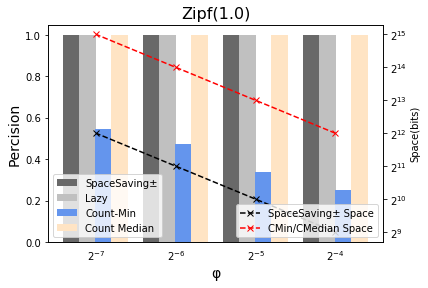

SS: {0.5: [1.0, 1.0, 1.0, 1.0]}
Lazy SS: {0.5: [1.0, 1.0, 1.0, 1.0]}
CM: {0.5: [0.25, 0.3371428571428571, 0.47272727272727266, 0.5468170426065163]}
CS: {0.5: [1.0, 1.0, 1.0, 1.0]}


In [47]:
    create_percision("zipf", [], 1.0)

20530780
0.0078125


/Users/owner/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: overflow encountered in long_scalars
/Users/owner/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: overflow encountered in long_scalars
/Users/owner/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: overflow encountered in long_scalars
/Users/owner/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: overflow encountered in long_scalars


0.00390625
0.001953125
0.0009765625


/Users/owner/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:234: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


[0.00728932024638131, 0.003644660123190655, 0.0018223300615953274, 0.0009111650307976637]
[0.0010839099296834787, 0.0005419549648417394, 0.0002709774824208697, 0.00013548874121043484]


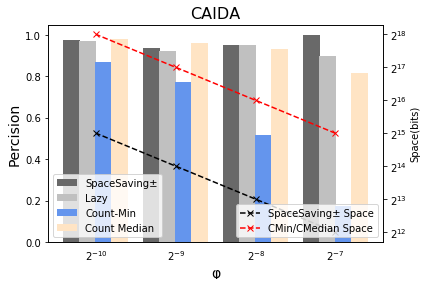

SS: {0.5: [1.0, 0.9529111405835545, 0.9362176095176288, 0.9730419221550788]}
Lazy SS: {0.5: [0.9, 0.9529111405835545, 0.921910653248337, 0.9687372560021099]}
CM: {0.5: [0.1716205533596838, 0.5166576988610887, 0.7717151621793035, 0.8705250763362716]}
CS: {0.5: [0.8166666666666667, 0.931080459770115, 0.9600267573662684, 0.9785510646859906]}


In [48]:
df = pd.read_csv('./data/tcp/20151217_125911_dirA.csv',sep='\t')  
dip = df[df.columns[3]]
print(len(dip))
create_percision("CAIDA", dip)

In [26]:
    def frequency_estimation(stream_type, shuffled, arr, skew=1.0, s = 10**5, univ = 2**16):
        ss_avg = {}
        lazy_ss_avg = {}
        csss_avg = {}
        cm_avg = {}
        cs_avg = {}
        
        total_spaces = {}
    
        Turnstile_model_maker = ['^:','^-.']
        markers = {0.5:['kv-','kv--','kv:']}
        runs = 5
        universe = univ
        size = s
        R = size # assume we can capture R without any error used for CSSS Sketch
        a = skew

        epsilons = []
        if stream_type != 'bin':
            epsilons = [2**(-1),2**(-2),2**(-3),2**(-4)]
        else:
            epsilons = [0.8,0.6,0.4,0.2]
        rates = [0.5]
        alphas = [2]
        
        for i in range(len(rates)):
            rate = rates[i]
            alpha = alphas[i]
            ss_avg_errors = []
            lazy_ss_avg_errors = []
            csss_avg_errors = []
            cm_avg_errors = []
            cs_avg_errors = []

            total_space = []

            for eps in epsilons:
                sum_ss_avg_error = 0
                sum_lazy_ss_avg_error = 0
                sum_csss_avg_error = 0
                sum_cm_avg_error = 0
                sum_cs_avg_error = 0

                first_run = True

                for run in range(runs):

                    CSSS = CSSS_sketch(eps, universe, 1.0/eps, alpha)

                    # CSSS space output the total bits used
                    # SpaceSaving and Linear Sketch use logU bits per counter

                    ss_space = math.ceil( CSSS.space()/math.log2(universe) )

                    SS = SpaceSaving(ss_space)
                    LAZY_SS = SpaceSaving(ss_space, True)

                    CM = CountMinSketch( math.ceil(1.0*ss_space/math.log2(universe)), math.ceil(math.log2(universe))) #cols, rows
                    CS = CSSS_CountSketch(math.ceil(math.log2(universe)), math.ceil(1.0*ss_space/math.log2(universe)))

                    if first_run:
                        first_run = False
                        total_space.append(CSSS.space())

                    insertions = []
                    deletions = []
                    
                    # makeing sure size = |F| = I-D = insert_size(1-r)
                    insert_size = int(size/(1-rate))

                    if stream_type == 'zipf':
                        range_x = np.arange(1,universe)
                        weights = range_x ** (-a)
                        weights /= weights.sum()
                        bounded_zipf = stats.rv_discrete(name='bounded_zipf', values=(range_x, weights))

                        insertions = bounded_zipf.rvs(size=insert_size)
                        if shuffled:
                            deletions = random.sample(list(insertions), int(rate*insert_size))

                    elif stream_type == 'bin':
                        insertions = list(np.random.binomial(universe, a, insert_size))
                        if shuffled:
                            deletions = random.sample(list(insertions), int(rate*insert_size))
                        
                    else:
                        assert(len(arr)>0)
                        insertions = arr[run*CAIDASIZE:(run+1)*CAIDASIZE]
                        if shuffled:
                            deletions = random.sample(list(insertions), int(rate*len(insertions)))

                    if not shuffled:
                        dic = collections.Counter(insertions)
                        ordered_dic = collections.OrderedDict(sorted(dic.items(), key=operator.itemgetter(1)))
                        targeted_length = int(rate*len(insertions))
                        for item, val in ordered_dic.items():
                            for i in range(val):
                                if len(deletions)<targeted_length:
                                    deletions.append(item)
                                else:
                                    break
                            if len(deletions)>=targeted_length:
                                break


                    true_result = {}
                    for i in insertions:
                        CSSS.update(str(i), 1)
                        SS.update(str(i), 1)
                        LAZY_SS.update(str(i), 1)
                        CM.add(str(i), 1)
                        CS.add(str(i), 1)
                        true_result[str(i)] = true_result.get(str(i), 0) + 1

                    for i in deletions:
                        CSSS.update(str(i), -1)
                        SS.update(str(i), -1)
                        LAZY_SS.update(str(i), -1)
                        CM.add(str(i), -1)
                        CS.add(str(i), -1)
                        true_result[str(i)] -= 1

    
                    csss_avg_error = 0

                    ss_avg_error = 0
                    lazy_ss_avg_error = 0

                    cm_avg_error = 0
                    cs_avg_error = 0

                    for item in true_result.keys():
                        csss_estimate = CSSS.query(item)
                        csss_error = abs(true_result.get(item,0) - csss_estimate)

                        ss_estimate = SS.query(item)
                        ss_error = abs(true_result.get(item,0) - ss_estimate)

                        lazy_ss_estimate = LAZY_SS.query(item)
                        lazy_ss_error = abs(true_result.get(item,0) - lazy_ss_estimate)

                        cm_estimate = CM.query(item)
                        cm_error = abs(true_result.get(item,0) - cm_estimate)

                        cs_estimate = CS.query(item)
                        cs_error = abs(true_result.get(item,0) - cs_estimate)



                        csss_avg_error += csss_error**2
                        ss_avg_error += ss_error**2
                        lazy_ss_avg_error += lazy_ss_error**2
                        cm_avg_error += cm_error**2
                        cs_avg_error += cs_error**2

                    u = len(true_result.keys())
                    csss_avg_error = 1.0*csss_avg_error / u
                    ss_avg_error = 1.0*ss_avg_error / u
                    lazy_ss_avg_error = 1.0*lazy_ss_avg_error / u
                    cm_avg_error = 1.0*cm_avg_error / u
                    cs_avg_error = 1.0*cs_avg_error / u

                    sum_ss_avg_error += ss_avg_error
                    sum_lazy_ss_avg_error += lazy_ss_avg_error
                    sum_csss_avg_error += csss_avg_error
                    sum_cm_avg_error += cm_avg_error
                    sum_cs_avg_error += cs_avg_error

                ss_avg_errors.append(sum_ss_avg_error/ runs)
                lazy_ss_avg_errors.append(sum_lazy_ss_avg_error/ runs)

                csss_avg_errors.append(sum_csss_avg_error/ runs)

                cm_avg_errors.append(sum_cm_avg_error/ runs)
                cs_avg_errors.append(sum_cs_avg_error/ runs)

            ss_avg[rate] = ss_avg_errors
            lazy_ss_avg[rate] = lazy_ss_avg_errors
            csss_avg[rate] = csss_avg_errors
            cm_avg[rate] = cm_avg_errors
            cs_avg[rate] = cs_avg_errors
            total_spaces[rate] = total_space


        plt.figure()
        if stream_type == 'zipf':
            if shuffled:
                plt.title("Zipf("+str(a)+") Distribution", fontsize=16) 
            else:
                plt.title("Zipf("+str(a)+") Distribution, Delete Least Frequent", fontsize=16) 
            plt.ylim([10**1, 10**9])
        elif stream_type == 'bin':
            if shuffled:
                plt.title("Binomial("+str(a)+") Distribution", fontsize=16)
            else:
                plt.title("Binomial("+str(a)+") Distribution, Delete Least Frequent", fontsize=16)
            plt.ylim([10**3, 10**9])
        else:
            if shuffled:
                plt.title(str(stream_type)+" Dataset", fontsize=16) 
            else:
                plt.title(str(stream_type)+" Dataset, Least Frequent", fontsize=16) 
            plt.ylim([10**2.5, 10**11])
                
            
        plt.xlabel('Space(bits)', fontsize=14)
        plt.ylabel('MSE', fontsize=14)
        plt.yscale('log', basey=10)
        plt.xscale('log', basex=2)
        for i in range(len(rates)):
            plt.plot(total_spaces[rates[i]], ss_avg[rates[i]], markers[rates[i]][0], label='SpaceSaving\u00B1, '+"D"+str(rates[i]))
            plt.plot(total_spaces[rates[i]], lazy_ss_avg[rates[i]], markers[rates[i]][2], label='Lazy, '+"D"+str(rates[i]))
            plt.plot(total_spaces[rates[i]], csss_avg[rates[i]], markers[rates[i]][1],label='CSSS, '+"D"+str(rates[i]))
            plt.plot(total_spaces[rates[i]], cm_avg[rates[i]], Turnstile_model_maker[0] ,label='Count-Min, '+"D"+str(rates[i]))
            plt.plot(total_spaces[rates[i]], cs_avg[rates[i]], Turnstile_model_maker[1],label='Count Median, '+"D"+str(rates[i]))
        print(total_spaces)
        print(ss_avg)
        print(lazy_ss_avg)
        print(csss_avg)
        print(cm_avg)
        print(cs_avg)
        plt.legend(prop={'size': 10})
        

Desired Space:  0.5
CSSS Space:  1152
Desired Space:  0.25
CSSS Space:  2688
Desired Space:  0.125
CSSS Space:  6144
Desired Space:  0.0625
CSSS Space:  13824
{0.5: [1152, 2688, 6144, 13824]}
{0.5: [2908.959067254839, 1015.3548022715568, 351.43418411979, 115.75110548247599]}
{0.5: [9798.789153532054, 3373.780092348571, 1144.6041761232589, 371.80685451045053]}
{0.5: [25685030.893902067, 2384101.435193217, 193784.3809064605, 91457.57133424065]}
{0.5: [208798546.0790347, 35833671.8377067, 5895965.775409555, 899683.5720354207]}
{0.5: [1050047.779137607, 275426.26772123174, 51379.8232084558, 12595.223849946433]}


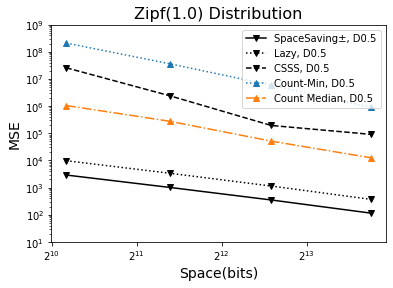

In [53]:
    frequency_estimation('zipf', True, [], 1.0)

Desired Space:  0.5
CSSS Space:  1152
Desired Space:  0.25
CSSS Space:  2688
Desired Space:  0.125
CSSS Space:  6144
Desired Space:  0.0625
CSSS Space:  13824
{0.5: [1152, 2688, 6144, 13824]}
{0.5: [1862.7694892446616, 504.5408915870963, 127.5203451332774, 27.21936829831307]}
{0.5: [10416.979787855302, 3505.0366067357636, 1157.7485591540085, 370.8123819008559]}
{0.5: [25376937.978002705, 1459230.4949250882, 269106.29913143796, 97838.65228075438]}
{0.5: [84060657.93332165, 9286769.946157575, 635309.2353114241, 24624.43005192942]}
{0.5: [5086297.388290542, 882171.8843569045, 205079.66459884943, 51241.95325222353]}


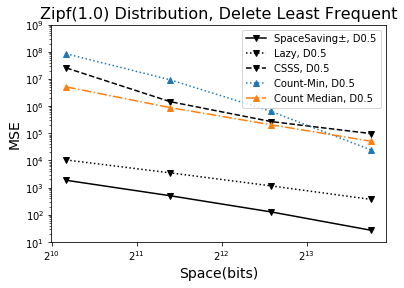

In [54]:
    frequency_estimation('zipf', False, [], 1.0)

Desired Space:  0.8
CSSS Space:  1021
Desired Space:  0.6
CSSS Space:  1101
Desired Space:  0.4
CSSS Space:  1820
Desired Space:  0.2
CSSS Space:  3514
{0.5: [1021, 1101, 1820, 3514]}
{0.5: [203933.47632961546, 186643.04653655214, 98561.53926789672, 21811.383687486777]}
{0.5: [657108.3427995022, 589034.632021541, 250317.7043914871, 40967.255051974964]}
{0.5: [27075358.29732399, 30683987.436909355, 8949620.040448539, 7906652.201861869]}
{0.5: [430447519.2522521, 245139652.35365185, 83548764.1303755, 19061426.35249411]}
{0.5: [156302.55389893305, 101035.50895728215, 116377.66169624678, 81902.11578667231]}


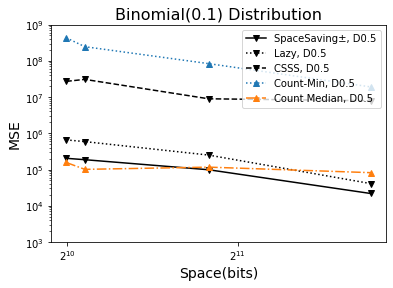

In [55]:
    frequency_estimation('bin', True, [], 0.1)

Desired Space:  0.8
CSSS Space:  1021
Desired Space:  0.6
CSSS Space:  1101
Desired Space:  0.4
CSSS Space:  1820
Desired Space:  0.2
CSSS Space:  3514
{0.5: [1021, 1101, 1820, 3514]}
{0.5: [239589.26384304505, 240685.4496213325, 120335.57741323559, 9636.099145034872]}
{0.5: [725111.6630448928, 679822.9049672731, 291590.7353806523, 34103.205825443794]}
{0.5: [18738551.706953563, 17421319.147135437, 27026638.869973622, 10038198.93166792]}
{0.5: [299723142.5610993, 180063482.32953286, 43860367.85288916, 8085801.16024283]}
{0.5: [602831.6155758597, 569779.8363630858, 487032.3825968492, 384017.72910927073]}


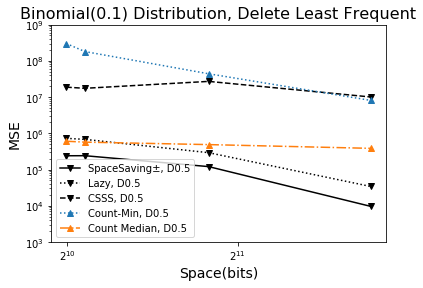

In [56]:
    frequency_estimation('bin', False, [],0.1)

In [30]:
df = pd.read_csv('./data/tcp/20151217_125911_dirA.csv',sep='\t')  
dip = df[df.columns[3]]

20530780


Desired Space:  0.5
CSSS Space:  1152


/Users/owner/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: overflow encountered in long_scalars
/Users/owner/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: overflow encountered in long_scalars
/Users/owner/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: overflow encountered in long_scalars
/Users/owner/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: overflow encountered in long_scalars


Desired Space:  0.25
CSSS Space:  2688
Desired Space:  0.125
CSSS Space:  6144
Desired Space:  0.0625
CSSS Space:  13824
{0.5: [1152, 2688, 6144, 13824]}
{0.5: [139620.1821922622, 53162.55795253039, 14889.517356683733, 4319.873463232103]}
{0.5: [482731.7053543253, 164487.52999182005, 48586.86534350597, 12961.899712682824]}
{0.5: [502499812.69369256, 38664284.28136345, 7656320.270747408, 3991726.0485151345]}
{0.5: [6035535428.296338, 1029047735.5301788, 166537879.18613335, 24692865.939967286]}
{0.5: [15354679.765938535, 3585338.033482749, 1492396.8714509788, 455646.8679452736]}


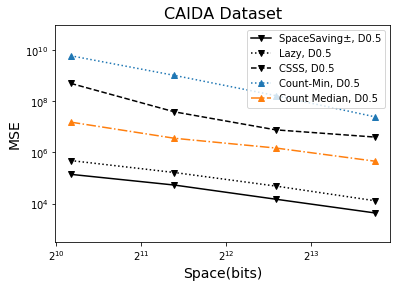

In [31]:
frequency_estimation('CAIDA', True, dip)

Desired Space:  0.5
CSSS Space:  1152


/Users/owner/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: overflow encountered in long_scalars
/Users/owner/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: overflow encountered in long_scalars
/Users/owner/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: overflow encountered in long_scalars
/Users/owner/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: overflow encountered in long_scalars


Desired Space:  0.25
CSSS Space:  2688
Desired Space:  0.125
CSSS Space:  6144
Desired Space:  0.0625
CSSS Space:  13824
{0.5: [1152, 2688, 6144, 13824]}
{0.5: [124006.01847044603, 40323.49733860432, 6419.659696799861, 1070.8330084766058]}
{0.5: [515031.62158185185, 176899.7894164588, 50316.82500825694, 12480.336683552043]}
{0.5: [714676012.8171604, 24633530.7524186, 11955871.82123592, 4162061.1091501242]}
{0.5: [3151956745.9397764, 384478181.57963765, 35366616.82462232, 2045547.920327107]}
{0.5: [57864255.77578455, 15969740.93631604, 5185523.797562154, 1676295.722530375]}


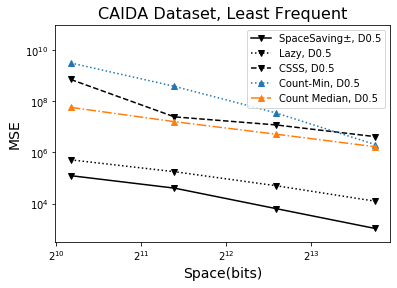

In [32]:
frequency_estimation('CAIDA', False, dip)

In [ ]:
import time
def update_time(stream_type, shuffled, arr, skew=1.0, u = 2**16):
    
        stream_length = [3**8, 3**9, 3**10, 3**11]
        
        ss_updatetime = {}
        lazy_ss_updatetime = {}
        csss_updatetime = {}
        cm_updatetime = {}
        cs_updatetime = {}

        total_spaces = {}
        Turnstile_model_maker = ['^:','^-.']
        markers = {0.5:['kv-','kv--','kv:', '*:', '*-.']}

        runs = 5
        universe = u
        a = skew
        rates = [0.5]
        alphas = [2]
        
        
        for i in range(len(rates)):
            rate = rates[i]
            alpha = alphas[i]

            ss_avg_updatetime = []        
            lazy_ss_avg_updatetime  = []
            csss_avg_updatetime = []        
            cm_avg_updatetime = []
            cs_avg_updatetime = []


            for j in range(len(stream_length)):
                size = stream_length[j]
            
                sum_ss_avg_updatetime = 0
                sum_lazy_ss_avg_updatetime = 0        
                sum_csss_avg_updatetime = 0           
                sum_cm_avg_updatetime = 0            
                sum_cs_avg_updatetime = 0

                first_run = True
            
                for run in range(runs):
                    #1000 logU counters
                    SS = SpaceSaving(1000)
                    LAZY_SS = SpaceSaving(1000, True)
                    CM = CountMinSketch(62, 16) #cols, rows
                    CS = CSSS_CountSketch(16, 62)
                    CSSS = CSSS_sketch(1.0/17, universe, 17, 2)
                    
                    insertions = []
                    deletions = []
                    
                    if stream_type == "zipf":
                        range_x = np.arange(1,universe)
                        weights = range_x ** (-a)
                        weights /= weights.sum()
                        bounded_zipf = stats.rv_discrete(name='bounded_zipf', values=(range_x, weights))

                        insert_size = int(size/(1-rate))
                        insertions = bounded_zipf.rvs(size=insert_size) 
                        
                        if shuffled:
                            deletions = random.sample(list(insertions), int(rate*insert_size))

                    start = time.time()
                    for item in insertions:
                        SS.update(str(item), 1)
                    for item in deletions:
                        SS.update(str(item), -1)
                    end = time.time()
                    SS_times = 1.0*(end-start)/(len(insertions)+len(deletions))
                    
                    start = time.time()
                    for item in insertions:
                        LAZY_SS.update(str(item), 1)
                    for item in deletions:
                        LAZY_SS.update(str(item), -1)
                    end = time.time()
                    LAZY_SS_times = 1.0*(end-start)/(len(insertions)+len(deletions))
                    
                    start = time.time()
                    for item in insertions:
                        CM.add(str(item), 1)
                    for item in deletions:
                        CM.add(str(item), -1)
                    end = time.time()
                    CM_times = 1.0*(end-start)/(len(insertions)+len(deletions))
                    
                    start = time.time()
                    for item in insertions:
                        CS.add(str(item), 1)
                    for item in deletions:
                        CS.add(str(item), -1)
                    end = time.time()
                    CS_times = 1.0*(end-start)/(len(insertions)+len(deletions))
                    
                    start = time.time()
                    for item in insertions:
                        CSSS.update(str(i), 1)
                    for item in deletions:
                        CSSS.update(str(i), -1)
                    end = time.time()
                    CSSS_times = 1.0*(end-start)/(len(insertions)+len(deletions))
                    


                    sum_ss_avg_updatetime += SS_times
                    sum_lazy_ss_avg_updatetime += LAZY_SS_times
                    sum_cm_avg_updatetime += CM_times
                    sum_cs_avg_updatetime += CS_times
                    sum_csss_avg_updatetime += CSSS_times

                ss_avg_updatetime.append(sum_ss_avg_updatetime/ runs)
                lazy_ss_avg_updatetime.append(sum_lazy_ss_avg_updatetime/ runs)
                cm_avg_updatetime.append(sum_cm_avg_updatetime/ runs)
                cs_avg_updatetime.append(sum_cs_avg_updatetime/ runs)
                csss_avg_updatetime.append(sum_csss_avg_updatetime/runs)
                
            ss_updatetime[rate] = ss_avg_updatetime
            lazy_ss_updatetime[rate] = lazy_ss_avg_updatetime
            cm_updatetime[rate] = cm_avg_updatetime
            cs_updatetime[rate] = cs_avg_updatetime
            csss_updatetime[rate] = csss_avg_updatetime

        fig = plt.figure()
        if stream_type == "zipf":
            if shuffled:
                plt.title("Zipf("+str(a)+") Update Time", fontsize=16) 

        plt.xlabel('Stream Length', fontsize=14)
        plt.ylabel('Time Per Item (sec)', fontsize=14)
        plt.yscale('log', basey=10)
        plt.xscale('log', basex=3)
        for i in range(len(rates)):
            plt.plot(stream_length, ss_updatetime[rates[i]], markers[rates[i]][0], label='SpaceSaving\u00B1')
            plt.plot(stream_length, lazy_ss_updatetime[rates[i]], markers[rates[i]][2], label='Lazy')
            plt.plot(stream_length, csss_updatetime[rates[i]], markers[rates[i]][1],label='CSSS')

            plt.plot(stream_length, cm_updatetime[rates[i]], Turnstile_model_maker[0] ,label='Count-Min')
            plt.plot(stream_length, cs_updatetime[rates[i]], Turnstile_model_maker[1],label='Count Median')
        plt.legend(prop={'size': 10})
        print('ss', ss_updatetime)
        print('lss', lazy_ss_updatetime)
        print('cm', cm_updatetime)
        print('cs', cs_updatetime)
        print('csss', csss_updatetime)
        

ss {0.5: [8.216493165947852e-06, 8.53366509737816e-06, 8.666771000220714e-06, 8.697878500815803e-06]}
lss {0.5: [6.089152125985691e-06, 6.665086687266282e-06, 6.300797655435633e-06, 6.316412553541365e-06]}
cm {0.5: [2.7532862895013404e-05, 2.7403746449244204e-05, 2.7396869003172806e-05, 2.751199063128331e-05]}
cs {0.5: [5.5235909875413236e-05, 5.466464686311774e-05, 5.5243124598976894e-05, 5.510047084497519e-05]}
csss {0.5: [6.9405207309103685e-06, 3.316928983879351e-06, 1.8377714893516112e-06, 1.3169464911419606e-06]}


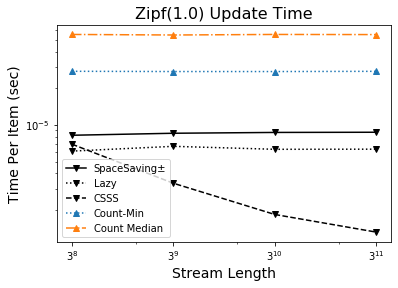

In [87]:
    update_time("zipf", True, [])

In [3]:
def different_delete_ratio_mse(stream_type, counters, shuffled, arr, skew=1.0, u = 2**16):
    
        stream_length = [10**6]
        
        ss_mse_errors = {}
        lazy_mse_errors = {}
        csss_mse_errors = {}
        cm_mse_errors = {}
        cs_mse_errors = {}

        Turnstile_model_maker = ['^:','^-.']
        markers = {stream_length[0]:['bo-','bo--', 'bo:', '^:','^-.'], 0.5:['kv-','kv--','kv:', '*:', '*-.'], 0.25:['rP-','rP--', 'rP:']}

        runs = 5
        universe = u
        a = skew
        rates = [0.25, 0.5, 0.75, 0.9, (1-1.0/16)]
        alphas = [4/3, 2, 4, 10, 16]
        
        counters = counters
        
        for j in range(len(stream_length)):
            size = stream_length[j]

            ss_avg_mse_error = []        
            lazy_ss_avg_mse_error  = []
            csss_avg_mse_error = []        
            cm_avg_mse_error = []
            cs_avg_mse_error = []


            for i in range(len(rates)):
                rate = rates[i]
                alpha = alphas[i]
            
                sum_ss_mse_error = 0
                sum_lazy_ss_mse_error = 0        
                sum_csss_mse_error = 0           
                sum_cm_mse_error = 0            
                sum_cs_mse_error = 0

                first_run = True
            
                for run in range(runs):
                    SS = SpaceSaving(counters)
                    LAZY_SS = SpaceSaving(counters, True)
                    CM = CountMinSketch(counters/16.0, 16) # cols, rows
                    CS = CSSS_CountSketch(16, counters/16.0)
                    csssK = counters/(math.log2(alpha)) #
                    CSSS = CSSS_sketch(1.0/csssK, universe, csssK, 2)
                    
                    insertions = []
                    deletions = []
                    
                    if stream_type == "zipf":
                        range_x = np.arange(1,universe)
                        weights = range_x ** (-a)
                        weights /= weights.sum()
                        bounded_zipf = stats.rv_discrete(name='bounded_zipf', values=(range_x, weights))

                        insert_size = int(size/(1+rate))
                        insertions = bounded_zipf.rvs(size=insert_size) 
                        
                        if shuffled:
                            deletions = random.sample(list(insertions), int(rate*insert_size))
                            
                    true_result = {}
                    for item in insertions:
                        SS.update(str(item), 1)
                        LAZY_SS.update(str(item), 1)
                        CM.add(str(item), 1)
                        CS.add(str(item), 1)
                        CSSS.update(str(item), 1)
                        true_result[str(item)] = true_result.get(str(item), 0) + 1
                        
                    for item in deletions:
                        SS.update(str(item), -1)
                        LAZY_SS.update(str(item), -1)
                        CM.add(str(item), -1)
                        CS.add(str(item), -1)
                        CSSS.update(str(item), -1)
                        true_result[str(item)] -= 1
                        if true_result[str(item)] == 0:
                            del true_result[str(item)]
                        
                    
                    csss_sum_mse_error = 0
                    ss_sum_mse_error = 0
                    lazy_ss_sum_mse_error = 0
                    cm_sum_mse_error = 0
                    cs_sum_mse_error = 0
                    
                    total_items = 0
                    for item, freq in true_result.items():
                        total_items+=1
                        
                        csss_estimate = CSSS.query(item)
                        csss_sum_mse_error += (freq - csss_estimate)**2
            
                        ss_estimate = SS.query(item)
                        ss_sum_mse_error += (freq - ss_estimate)**2
                    
                        lazy_ss_estimate = LAZY_SS.query(item)
                        lazy_ss_sum_mse_error += (freq - lazy_ss_estimate)**2

                        cm_estimate = CM.query(item)
                        cm_sum_mse_error += (freq - cm_estimate)**2

                        cs_estimate = CS.query(item)
                        cs_sum_mse_error += (freq - cs_estimate)**2
                    
                    sum_ss_mse_error += (1.0 * ss_sum_mse_error / len(true_result.items()) )
                    sum_lazy_ss_mse_error +=  (1.0 * lazy_ss_sum_mse_error / len(true_result.items()) )
                    sum_csss_mse_error += (1.0 * csss_sum_mse_error/ len(true_result.items()))        
                    sum_cm_mse_error += (1.0 * cm_sum_mse_error/ len(true_result.items()))            
                    sum_cs_mse_error += (1.0 * cs_sum_mse_error/ len(true_result.items()))
            
                ss_avg_mse_error.append(1.0 * sum_ss_mse_error/ runs)
                lazy_ss_avg_mse_error.append(1.0 * sum_lazy_ss_mse_error/ runs)
                cm_avg_mse_error.append(1.0 * sum_cm_mse_error / runs)
                cs_avg_mse_error.append(1.0 * sum_cs_mse_error / runs)
                csss_avg_mse_error.append(1.0 * sum_csss_mse_error / runs)
            
        
            ss_mse_errors[size] = ss_avg_mse_error
            lazy_mse_errors[size] = lazy_ss_avg_mse_error
            cm_mse_errors[size] = cm_avg_mse_error
            cs_mse_errors[size] = cs_avg_mse_error
            csss_mse_errors[size] = csss_avg_mse_error

        fig = plt.figure()
        if stream_type == "zipf":
            if shuffled:
                plt.title("Zipf("+str(a)+")", fontsize=16) 
            
        plt.xlabel('Delete:Insert Ratio', fontsize=14)
        plt.ylabel('MSE', fontsize=14)
        plt.yscale('log', basey=10)
        plt.xticks(rates) 
        #plt.autofmt_xdate() 
        plt.gcf().autofmt_xdate()
        print('ss', ss_mse_errors)
        print('lss', lazy_mse_errors)
        print('cm', cm_mse_errors)
        print('cs', cs_mse_errors)
        print('csss', csss_mse_errors)
        for s in stream_length:
            plt.plot(rates, ss_mse_errors[s], markers[0.5][0], label='SpaceSaving\u00B1')
            plt.plot(rates, lazy_mse_errors[s], markers[0.5][2], label='Lazy')
            plt.plot(rates, csss_mse_errors[s], markers[size][1],label='CSSS')

            plt.plot(rates, cm_mse_errors[s], Turnstile_model_maker[0] ,label='Count-Min')
            plt.plot(rates, cs_mse_errors[s], Turnstile_model_maker[1],label='Count Median')
        plt.legend(prop={'size': 10})

coutners:  1000
0.25 1.3333333333333333
0.00041503749927884374
0.5 2
0.001
0.75 4
0.002
0.9 10
0.0033219280948873623
0.9375 16
0.004
ss {1000000: [1920.8328027611205, 781.4899679093345, 304.20366882509273, 247.4628484118789, 312.29659158180885]}
lss {1000000: [3136.176654196489, 2483.700499252959, 2351.161602779767, 2856.2065221314056, 3189.9705470056806]}
cm {1000000: [23053078.912752222, 7076611.099366702, 1293384.8481406844, 173294.85297084477, 64328.84884706149]}
cs {1000000: [283571.360285383, 107672.99791432056, 17424.322504171814, 3046.9227150988327, 855.8967072094695]}
csss {1000000: [336153.27595008106, 401152.5227379367, 727316.5436204836, 1075197.4943334386, 1332423.033524604]}


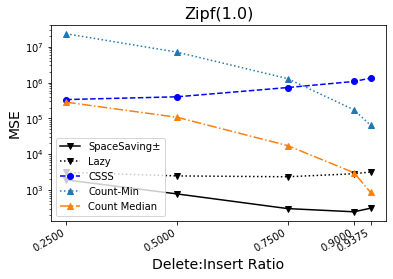

In [12]:
    different_delete_ratio_mse("zipf", 1000, True, [])